1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

"wget" non è riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [82]:
import pandas as pd

file_name = "data_000637.txt"
data = pd.read_csv(file_name, nrows = 1000000)
print("I'll use 10^6 rows")
data

I'll use 10^6 rows


,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
999995,1,0,62,3869209011,2560,29
999996,1,0,51,3869209011,2561,12
999997,1,0,61,3869209011,2562,2
999998,1,0,50,3869209011,2563,4


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [83]:
data['BX_COUNTER'].max()

3563

3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [84]:
data['ABSOLUTE_TIME'] = (data['ORBIT_CNT']-3869200167)*(3564*25)+(data['BX_COUNTER']-2374)*25+(data['TDC_MEAS']-26)*25/30
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABSOLUTE_TIME
0,1,0,123,3869200167,2374,26,0.000000e+00
1,1,0,124,3869200167,2374,27,8.333333e-01
2,1,0,63,3869200167,2553,28,4.476667e+03
3,1,0,64,3869200167,2558,19,4.594167e+03
4,1,0,64,3869200167,2760,25,9.649167e+03
...,...,...,...,...,...,...,...
999995,1,0,62,3869209011,2560,29,7.880051e+08
999996,1,0,51,3869209011,2561,12,7.880051e+08
999997,1,0,61,3869209011,2562,2,7.880051e+08
999998,1,0,50,3869209011,2563,4,7.880051e+08


4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [85]:
pd.to_timedelta(data['ABSOLUTE_TIME'].iloc[-1], unit='ns')

Timedelta('0 days 00:00:00.788008249')

5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [86]:
freq = data.groupby(["TDC_CHANNEL"]).size()
print("The 3 TDC channels with most counts are")
freq.sort_values(ascending=False).head(3)

The 3 TDC channels with most counts are


TDC_CHANNEL
139    82677
64     50201
63     49335
dtype: int64

6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [87]:
non_empty = set(data['ORBIT_CNT'])
print(len(non_empty))

8841


7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [88]:
tdc_139 = data[data['TDC_CHANNEL'] == 139]
tdc_139_orbits = set(tdc_139['ORBIT_CNT'])
print(len(tdc_139_orbits))

8816


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [89]:
data_1 = data[data['FPGA'] == 0] 
data_2 = data[data['FPGA'] == 1]

freq_1 = []
for i in range(1, 140):
    freq_1.append(data_1[data_1['TDC_CHANNEL'] == i].shape[0])
    
freq_2 = []
for i in range(1, 140):
    freq_2.append(data_2[data_2['TDC_CHANNEL'] == i].shape[0])
    
series_1 = pd.Series(freq_1, range(1, 140))
series_2 = pd.Series(freq_2, range(1, 140))

print("FPGA 1\n", series_1, '\n\n')
print("FPGA 2\n", series_2)

FPGA 1
 1        933
2       1207
3       1156
4       1794
5       1096
       ...  
135        0
136        0
137       23
138       25
139    57878
Length: 139, dtype: int64 


FPGA 2
 1      21622
2      24871
3      16725
4      20087
5      11375
       ...  
135        0
136        0
137       27
138       27
139    24799
Length: 139, dtype: int64


9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

Text(0.5, 1.0, 'FPGA 2')

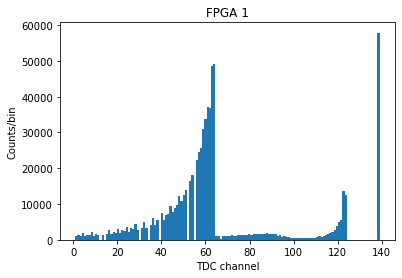

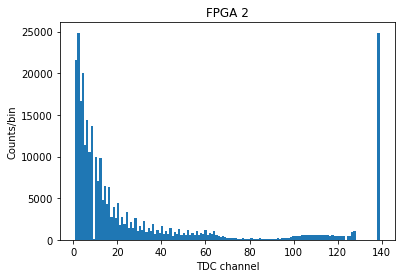

In [90]:
data_1.hist(column = 'TDC_CHANNEL', bins=139, grid = False)
plt.xlabel("TDC channel")
plt.ylabel("Counts/bin")
plt.title("FPGA 1")

data_2.hist(column = 'TDC_CHANNEL', bins=139, grid = False)
plt.xlabel("TDC channel")
plt.ylabel("Counts/bin")
plt.title("FPGA 2")